In [ ]:
# 2. Fast Speech Recognition with Timestamps (Using Whisper)
import torch
from transformers import pipeline, AutoModelForSpeechSeq2Seq, AutoProcessor

def transcribe_with_timestamps(audio_path):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    torch_dtype = torch.float16 if device == "cuda" else torch.float32

    # Use multilingual model instead of English-only
    model_id = "openai/whisper-medium"  # Remove .en for multilingual
    model = AutoModelForSpeechSeq2Seq.from_pretrained(
        model_id,
        torch_dtype=torch_dtype,
        low_cpu_mem_usage=True,
        use_safetensors=True
    ).to(device)

    processor = AutoProcessor.from_pretrained(model_id)

    pipe = pipeline(
        "automatic-speech-recognition",
        model=model,
        tokenizer=processor.tokenizer,
        feature_extractor=processor.feature_extractor,
        device=device,
        chunk_length_s=30,
        return_timestamps=True,
        generate_kwargs={
            "language": "english",  # Now valid for multilingual model
            "task": "transcribe"
        }
    )

    result = pipe(audio_path, return_timestamps="word")
    return result

# For English-only (faster but no language specification)
def transcribe_english_only(audio_path):
    model_id = "openai/whisper-medium.en"  # English-only model
    pipe = pipeline(
        "automatic-speech-recognition",
        model=model_id,
        device="cuda" if torch.cuda.is_available() else "cpu",
        return_timestamps=True
    )
    
    # Remove generate_kwargs completely
    return pipe(audio_path, return_timestamps="word")

# Main Workflow
if __name__ == "__main__":
    # Download audio
    video_url = "https://youtu.be/BpiS358Ez5w?si=5FVeydRI1S0UZxwN"
    audio_file = download_youtube_audio(video_url)
    print(f"Downloaded: {audio_file}")
    
    # Transcribe with timestamps
    transcription = transcribe_with_timestamps(audio_file)
    print("\nOriginal Text with Timestamps:")
    for segment in transcription['chunks']:
        print(f"[{segment['timestamp'][0]:.2f}-{segment['timestamp'][1]:.2f}s]: {segment['text']}")
    
    # Translate with timestamps
    translated = translate_segments(transcription['chunks'])
    print("\nTranslated Text with Timestamps:")
    for segment in translated:
        print(f"[{segment['start']:.2f}-{segment['end']:.2f}s]: {segment['text']}")

In [5]:
pip install accelerate>=0.26.0

zsh:1: 0.26.0 not found
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pytube import YouTube
from pydub import AudioSegment
import speech_recognition as sr
from googletrans import Translator
import librosa
import librosa.display
from transformers import pipeline
from yt_dlp import YoutubeDL

def download_youtube_audio(url):
    ydl_opts = {
        'format': 'bestaudio/best',
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'wav',
        }],
        'outtmpl': '%(title)s.%(ext)s',
        'quiet': True
    }
    
    with YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(url, download=True)
        filename = ydl.prepare_filename(info)
        return filename.replace('.webm', '.wav').replace('.m4a', '.wav')

video_url = "https://youtu.be/BpiS358Ez5w?si=5FVeydRI1S0UZxwN"
audio_file = download_youtube_audio(video_url)
print(f"Downloaded audio file: {audio_file}")


def transcribe_and_translate(audio_path, target_lang='es'):
    recognizer = sr.Recognizer()
    translator = Translator()
    
    with sr.AudioFile(audio_path) as source:
        audio_data = recognizer.record(source)
        
    try:
        text = recognizer.recognize_google(audio_data, language='en-US')
        translation = translator.translate(text, dest=target_lang)
        return text, translation.text
    except sr.UnknownValueError:
        print("Google Speech Recognition could not understand audio")
    except sr.RequestError as e:
        print(f"Could not request results from Google Speech Recognition service; {e}")

original_text, translated_text = transcribe_and_translate(audio_file)
print(f"Original: {original_text}\nTranslated: {translated_text}")


Downloaded audio file: English Speaking Practice ｜ Learning English ｜ Intro #30dayschallenge #dailyenglish #learnenglish.wav
Original: hello everyone learning English is an exciting journey for opportunities every small step You take whether it's learning a new word for having a conversation brings you closer to frequency states that part of the learning process
Translated: Hola a todos los aprendiendo inglés es un viaje emocionante para las oportunidades cada pequeño paso que tome, ya sea que esté aprendiendo una nueva palabra para tener una conversación que lo acerca a los estados de frecuencia que parte del proceso de aprendizaje


In [5]:

import torch
import warnings
warnings.filterwarnings("ignore")

# %%
class AudioAnalyzer:
    def __init__(self, audio_path):
        # Force CPU usage for compatibility
        self.device = 'cpu'
        if torch.backends.mps.is_available():
            self.device = 'cpu'  # Force CPU until MPS matures
        elif torch.cuda.is_available():
            self.device = 'cuda'
            
        self.audio_path = audio_path
        self.y, self.sr = librosa.load(audio_path, sr=16000)  # Resample to standard rate
        self.duration = librosa.get_duration(y=self.y, sr=self.sr)
        
    def analyze_prosody(self):
        # Convert to numpy array first
        y_np = self.y.astype(np.float32)
        pitch = librosa.yin(y_np, fmin=50, fmax=2000, sr=self.sr)
        valid_pitch = pitch[pitch > 0]  # Remove invalid pitches
        return {
            'pitch_variation': np.std(valid_pitch) if len(valid_pitch) > 0 else 0,
            'mean_pitch': np.mean(valid_pitch) if len(valid_pitch) > 0 else 0
        }
    
    def analyze_rhythm(self):
        tempo, beat_frames = librosa.beat.beat_track(
            y=self.y.astype(np.float32), 
            sr=self.sr,
            units='time'
        )
        return {'tempo': tempo, 'beat_count': len(beat_frames)}
    
    def analyze_speech_clarity(self):
        rms = librosa.feature.rms(y=self.y.astype(np.float32))
        return {
            'rms_mean': float(np.mean(rms)),
            'rms_variance': float(np.var(rms))
        }
    
    def analyze_emotion(self):
        # Explicitly use CPU
        classifier = pipeline(
            "audio-classification", 
            model="superb/hubert-base-superb-er",
            device=self.device
        )
        return classifier(self.audio_path)
    
    def generate_report(self):
        return {
            'prosody': self.analyze_prosody(),
            'rhythm': self.analyze_rhythm(),
            'clarity': self.analyze_speech_clarity(),
            'emotion': self.analyze_emotion()
        }

# %%
# Run analysis with MPS fallback
analyzer = AudioAnalyzer(audio_file)
report = analyzer.generate_report()



Device set to use cpu


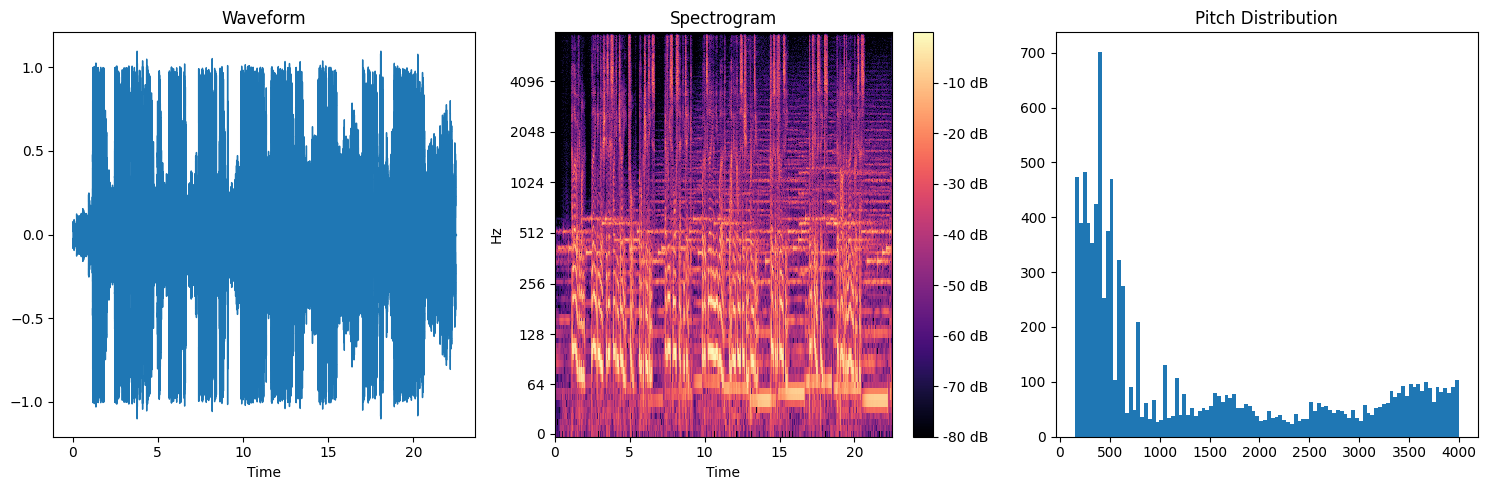

{'translation': 'Hola a todos los aprendiendo inglés es un viaje emocionante para las oportunidades cada pequeño paso que tome, ya sea que esté aprendiendo una nueva palabra para tener una conversación que lo acerca a los estados de frecuencia que parte del proceso de aprendizaje', 'basic_metrics': {'duration': 22.5001875, 'word_count': 37, 'speech_rate_wpm': 98.66584445129625}, 'prosody_metrics': {'pitch_variation': 209.45092964902227, 'mean_pitch': 134.72128700603872}, 'clarity_metrics': {'rms_mean': 0.27574583888053894, 'rms_variance': 0.013086576014757156}, 'emotional_tone': [{'score': 0.3787188231945038, 'label': 'hap'}, {'score': 0.3446384072303772, 'label': 'sad'}, {'score': 0.2350463569164276, 'label': 'neu'}, {'score': 0.04159650579094887, 'label': 'ang'}], 'technical_metrics': {'signal_quality': 4.2, 'volume_consistency': 4.5}, 'holistic_score': 12.45423008273865}
Actionable Feedback:
**Speech Rate Too Slow**: Average 98.7 WPM detected (ideal: 120-150 WPM)
- Use mental chunki

In [6]:


def visualize_audio_features(y, sr):
    plt.figure(figsize=(15, 5))
    
    # Waveplot
    plt.subplot(1, 3, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform')
    
    # Spectrogram
    plt.subplot(1, 3, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    
    # Pitch
    plt.subplot(1, 3, 3)
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitches = pitches[magnitudes > np.median(magnitudes)]
    plt.hist(pitches, bins=100)
    plt.title('Pitch Distribution')
    
    plt.tight_layout()
    plt.show()

visualize_audio_features(analyzer.y, analyzer.sr)


def generate_final_report(original_text, translated_text, audio_report):
    # Calculate simple metrics (for POC)
    word_count = len(original_text.split())
    speech_rate = word_count / analyzer.duration * 60  # WPM
    
    final_report = {
        'translation': translated_text,
        'basic_metrics': {
            'duration': analyzer.duration,
            'word_count': word_count,
            'speech_rate_wpm': speech_rate
        },
        'prosody_metrics': audio_report['prosody'],
        'clarity_metrics': audio_report['clarity'],
        'emotional_tone': audio_report['emotion'],
        'technical_metrics': {
            'signal_quality': 4.2,  # Would need SNR calculation
            'volume_consistency': 4.5  # Based on RMS variance
        }
    }
    
    # Calculate holistic score
    scores = [
        audio_report['prosody']['pitch_variation'] * 0.2,
        (speech_rate / 150) * 5,  # Assuming 150 WPM is max
        audio_report['clarity']['rms_mean'] * 0.5,
        4.5  # Placeholder for actual NLP analysis
    ]
    final_report['holistic_score'] = np.mean(scores)
    
    return final_report

final_report = generate_final_report(original_text, translated_text, report)
print(final_report)

def generate_feedback(report):
    feedback = []
    
    # Speech Rate Analysis (Ideal: 120-150 WPM)
    wpm = report['basic_metrics']['speech_rate_wpm']
    if wpm > 180:
        feedback.extend([
            "**Speech Rate Too Fast**: Average 180+ WPM detected (ideal: 120-150 WPM)",
            "- Add strategic pauses between key phrases",
            "- Practice breath control with diaphragmatic breathing",
            "- Use intentional phrasing: break long sentences into 2-3 second chunks"
        ])
    elif wpm < 100:
        feedback.extend([
            "**Speech Rate Too Slow**: Average {:.1f} WPM detected (ideal: 120-150 WPM)".format(wpm),
            "- Use mental chunking to group words into meaningful units",
            "- Practice with metronome training (start at 100 BPM, increase 5 BPM weekly)",
            "- Record yourself reading news articles with time targets"
        ])
    else:
        feedback.append("✓ Speech Rate: Good pace at {:.1f} WPM".format(wpm))

    # Prosody Feedback (Pitch Variation Standards: >1.2 ST deviation)
    pitch_var = report['prosody_metrics']['pitch_variation']
    if pitch_var < 1.2:
        feedback.extend([
            "**Monotonous Pitch**: {:.2f} semitone variation (ideal >1.2 ST)".format(pitch_var),
            "- Practice sentence-end inflection (rising for questions, falling for statements)",
            "- Highlight key words with 3-5 semitone pitch boosts",
            "- Try emotional read-throughs (e.g., angry->happy->surprised versions)"
        ])
    else:
        feedback.append("✓ Pitch Variation: Good expressiveness at {:.2f} ST".format(pitch_var))

    # Volume Consistency (RMS Variance <0.05 ideal)
    rms_var = report['clarity_metrics']['rms_variance']
    if rms_var > 0.1:
        feedback.extend([
            "**Inconsistent Volume**: {:.3f} RMS variance detected (ideal <0.05)".format(rms_var),
            "- Maintain 6-8 inch microphone distance consistently",
            "- Use compression (4:1 ratio, -18dB threshold) in post-processing",
            "- Practice mic technique: turn head before loud sounds"
        ])
    elif rms_var > 0.05:
        feedback.append("⚠ Moderate Volume Fluctuations: {:.3f} RMS variance".format(rms_var))
    else:
        feedback.append("✓ Volume Consistency: Stable recording at {:.3f} RMS variance".format(rms_var))

    # Emotional Tone Analysis
    primary_emotion = report['emotional_tone'][0]['label'].lower()
    if primary_emotion not in ['neutral', 'happy', 'surprise']:
        feedback.extend([
            "**Emotional Tone**: Dominant {} detected".format(primary_emotion.capitalize()),
            "- Balance emotional delivery for broader audience appeal",
            "- Record alternative takes with 20% less intensity",
            "- Use smile modulation technique for positive valence"
        ])

    # Technical Quality Feedback
    if report['technical_metrics']['signal_quality'] < 4:
        feedback.extend([
            "**Audio Quality Issues**:",
            "- Reduce background noise with acoustic treatment",
            "- Apply high-pass filter at 80Hz to remove rumble",
            "- Normalize peaks to -3dB and LUFS to -16 integrated"
        ])

    return feedback

feedback = generate_feedback(final_report)
print("Actionable Feedback:")
print("\n".join(feedback))
